In [1]:
import cv2
import os
import numpy as np
def load_images_from_directory(directory, target_size=(100, 100)):
    images = []
    for filename in os.listdir(directory):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            img_path = os.path.join(directory, filename)
            img = cv2.imread(img_path)
            if img is not None:
                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  
                img_resized = cv2.resize(img_rgb, target_size) 
                images.append(img_resized)
    return np.array(images)

In [2]:
anime_path = '/kaggle/input/animefacedataset/images'
anime_tensors = load_images_from_directory(anime_path, target_size=(64, 64))
print(anime_tensors.shape)

(63565, 64, 64, 3)


In [3]:
from tensorflow import keras
from keras.models import Model
from keras.layers import Dense, Conv2DTranspose, Conv2D, LeakyReLU, Input, Reshape, BatchNormalization, Flatten

2024-08-05 10:30:09.715554: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-05 10:30:09.715717: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-05 10:30:10.000737: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
def build_generator():
    input_layer=Input(shape=(100,))
    x=Dense(units=1024*4*4)(input_layer)
    x=BatchNormalization()(x)
    x=LeakyReLU(alpha=0.2)(x)
    x=Reshape((4,4,1024))(x)
    
    x=Conv2DTranspose(filters=512, strides=(2,2), kernel_size=(5,5), padding='same')(x)#8*8
    x=BatchNormalization()(x)
    x=LeakyReLU(alpha=0.2)(x)
    
    x=Conv2DTranspose(filters=256, strides=(2,2), kernel_size=(5,5), padding='same')(x)#16*16
    x=BatchNormalization()(x)
    x=LeakyReLU(alpha=0.2)(x)
    
    x=Conv2DTranspose(filters=128, strides=(2,2), kernel_size=(5,5), padding='same')(x)#32*32
    x=BatchNormalization()(x)
    x=LeakyReLU(alpha=0.2)(x)
    
    x=Conv2DTranspose(filters=3, strides=(2,2), kernel_size=(5,5), padding='same', activation='tanh')(x)#64*64
    
    model=Model(inputs=input_layer, outputs=x)
    return model

In [5]:
def build_discriminator():
    input_layer = Input(shape=(64, 64, 3))
    
    # First convolutional layer
    x = Conv2D(filters=64, kernel_size=(4, 4), strides=(2, 2), padding='same')(input_layer)
    x = LeakyReLU(alpha=0.2)(x)
    
    # Second convolutional layer
    x = Conv2D(filters=128, kernel_size=(4, 4), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    # Third convolutional layer
    x = Conv2D(filters=256, kernel_size=(4, 4), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    # Fourth convolutional layer
    x = Conv2D(filters=512, kernel_size=(4, 4), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    # Output layer
    x = Flatten()(x)
    x = Dense(1, activation='sigmoid')(x)
    
    model=Model(inputs=input_layer, outputs=x)
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

In [6]:
def combine(g_model, d_model):
    input_layer=Input(shape=(100,))
    d_model.trainable= False 
    fake_img=g_model(input_layer)
    validity=d_model(fake_img)
    model=Model(inputs=input_layer, outputs=validity)
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

In [7]:
anime_tensors=anime_tensors/127.5 -1

In [8]:
import matplotlib.pyplot as plt
def show(img):
    im=(img+1)/2
    im=(im*255).astype(np.uint8)
    plt.imshow(im)
    plt.show()

In [9]:
arr=np.random.randn(2,100)
test_g=build_generator()
img=test_g.predict(arr)
print(anime_tensors.shape[0])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
63565


I0000 00:00:1722853837.240369     108 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1722853837.258218     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [10]:
from keras import backend as K
import gc
def train(g_model, d_model, gan_model, epochs=5):
    batch_size=128
    half_batch=int(batch_size/2)
    batches=int(anime_tensors.shape[0]/batch_size)
    for epoch in range(epochs):
        print(f'epoch number {epoch+1} has started')
        c=0
        for batch in range(batches):
            c+=1
            
            #discriminator training of real samples
            indices=np.random.randint(0, anime_tensors.shape[0], half_batch)
            real_images=anime_tensors[indices]
            real_labels=np.ones(half_batch)
            real_loss=d_model.train_on_batch(real_images, real_labels)
            
            #discriminator training on fake samples
            vectors=np.random.randn(half_batch, 100)
            fake_images=g_model.predict(vectors)
            fake_labels=np.zeros(half_batch)
            fake_loss=d_model.train_on_batch(fake_images, fake_labels)
            
            #gan training 
            gan_noise=np.random.randn(batch_size, 100)
            gan_labels=np.ones(batch_size)
            gan_loss=gan_model.train_on_batch(gan_noise, gan_labels)
            
            #displaying the results
            print(f'epoch={epoch+1}, batch={batch+1}, real_loss={real_loss}, fake_loss={fake_loss} gan_loss={gan_loss}')
            if (c%100==0):
                arr=np.random.randn(1,100)
                img=g_model.predict(arr)
                show(img[0])
            
            
            K.clear_session()
            gc.collect()

epoch number 1 has started
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step
epoch=1, batch=1, real_loss=0.5887688398361206, fake_loss=6.666018486022949 gan_loss=[array(6.6660185, dtype=float32), array(6.6660185, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
epoch=1, batch=2, real_loss=4.444012641906738, fake_loss=9.297340393066406 gan_loss=[array(9.29734, dtype=float32), array(9.29734, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
epoch=1, batch=3, real_loss=7.437872409820557, fake_loss=8.355846405029297 gan_loss=[array(8.355846, dtype=float32), array(8.355846, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
epoch=1, batch=4, real_loss=7.162154197692871, fake_loss=6.2699689865112305 gan_loss=[array(6.269969, dtype=float32), array(6.269969, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
epoch=1, batch=5, real_loss=5.573305606842041, fake_loss=5.491801738739014 gan_loss=[array(5.4918017, dtype=float32), array(5.4918017, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/s

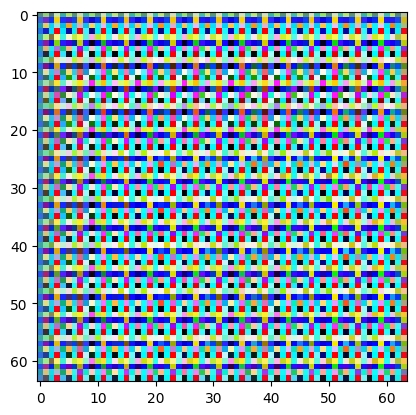

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
epoch=1, batch=101, real_loss=0.47344401478767395, fake_loss=0.47110849618911743 gan_loss=[array(0.4711085, dtype=float32), array(0.4711085, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
epoch=1, batch=102, real_loss=0.4687877595424652, fake_loss=0.4665790796279907 gan_loss=[array(0.46657908, dtype=float32), array(0.46657908, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
epoch=1, batch=103, real_loss=0.46430307626724243, fake_loss=0.46206191182136536 gan_loss=[array(0.4620619, dtype=float32), array(0.4620619, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
epoch=1, batch=104, real_loss=0.45983022451400757, fake_loss=0.45762521028518677 gan_loss=[array(0.4576252, dtype=float32), array(0.4576252, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
epoch=1, batch=105, real_loss=0.4554356634616852, fake_loss=0.4532736837863922 gan_loss=[array(0.45327368, dtype=float32), array(0.45327368, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 

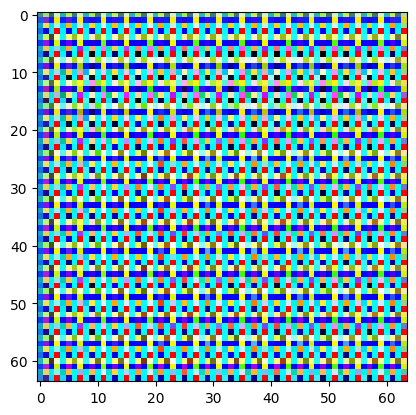

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
epoch=1, batch=201, real_loss=0.23780597746372223, fake_loss=0.23721688985824585 gan_loss=[array(0.23721689, dtype=float32), array(0.23721689, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
epoch=1, batch=202, real_loss=0.23662826418876648, fake_loss=0.23618711531162262 gan_loss=[array(0.23618712, dtype=float32), array(0.23618712, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
epoch=1, batch=203, real_loss=0.23560398817062378, fake_loss=0.2350248545408249 gan_loss=[array(0.23502485, dtype=float32), array(0.23502485, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
epoch=1, batch=204, real_loss=0.2344474494457245, fake_loss=0.23743954300880432 gan_loss=[array(0.23743954, dtype=float32), array(0.23743954, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
epoch=1, batch=205, real_loss=0.23685908317565918, fake_loss=0.23628683388233185 gan_loss=[array(0.23628683, dtype=float32), array(0.23628683, dtype=float32)]
2/2 ━━━━━━━━━━━━━

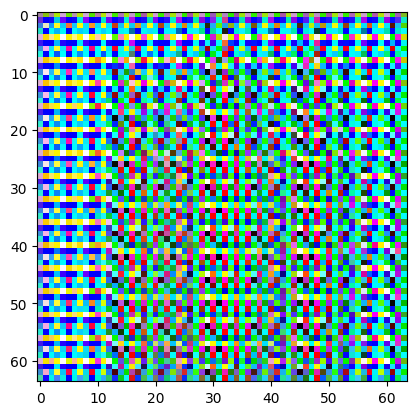

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
epoch=1, batch=301, real_loss=0.17644844949245453, fake_loss=0.1761559545993805 gan_loss=[array(0.17615595, dtype=float32), array(0.17615595, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
epoch=1, batch=302, real_loss=0.1758638471364975, fake_loss=0.17557324469089508 gan_loss=[array(0.17557324, dtype=float32), array(0.17557324, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
epoch=1, batch=303, real_loss=0.17528341710567474, fake_loss=0.17499978840351105 gan_loss=[array(0.17499979, dtype=float32), array(0.17499979, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
epoch=1, batch=304, real_loss=0.17471177875995636, fake_loss=0.17442826926708221 gan_loss=[array(0.17442827, dtype=float32), array(0.17442827, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
epoch=1, batch=305, real_loss=0.17414188385009766, fake_loss=0.1738608181476593 gan_loss=[array(0.17386082, dtype=float32), array(0.17386082, dtype=float32)]
2/2 ━━━━━━━━━━━━━━

In [ ]:
g_model=build_generator()
d_model=build_discriminator()
gan_model=combine(g_model, d_model)
train(g_model, d_model, gan_model)